<a href="https://colab.research.google.com/github/AdhirajChaddha/FootballGame/blob/master/CIFAR10_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

print("Training on GPU: ", train_on_gpu)

Training on GPU:  True


In [34]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

batchSize = 20
validationSize = 0.2

transformsTrain = transforms.Compose([
#     transforms.Pad(1),
#     transforms.RandomGrayscale(),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
    
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transformsTest = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Download training and testing data
trainingData = datasets.CIFAR10('data', train=True, 
                                transform=transformsTrain, download=True)

testingData = datasets.CIFAR10('data', train=False, 
                                transform=transformsTest, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
# Devide the data int0 training and validation sets
length = len(trainingData)
indices = list(range(length))
np.random.shuffle(indices)
split = (int)(length*validationSize)
train_idx, val_idx = idices[:split], indices[split:]

# Put the inices into the samplers for making dataloader
trainSampler = SubsetRandomSampler(train_idx)
validationSampler = SubsetRandomSampler(val_idx)

# Create the data loaders
trainLoader = torch.utils.data.DataLoader(trainingData, batch_size=batchSize,
    sampler=trainSampler)
valLoader = torch.utils.data.DataLoader(trainingData, batch_size=batchSize,
    sampler=validationSampler)
testLoader = torch.utils.data.DataLoader(testingData, batch_size=batchSize)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

torch.Size([20, 3, 32, 32])


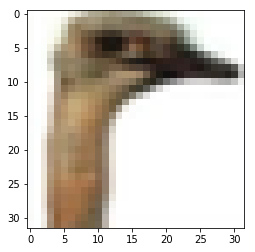

In [37]:
dataiter = iter(trainLoader)
images, labels = dataiter.next()

print(images.shape)

imshow(images.cpu()[0])

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    
    self.maxPool = nn.MaxPool2d(2, 2)
    
    self.fc1 = nn.Linear(4*4*64, 500)
    self.fc2 = nn.Linear(500, 10)
    
    self.dropout = nn.Dropout(0.2)
    
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.maxPool(x)
    
    x = F.relu(self.conv2(x))
    x = self.maxPool(x)
    
    x = F.relu(self.conv3(x))
    x = self.maxPool(x)
    
    x = x.view(-1, 4*4*64)
    
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    
    return x

In [0]:
model = CNN()

if train_on_gpu:
  model.cuda()
  
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.01)
LossFunction = nn.CrossEntropyLoss()

In [40]:
epochs = 30

# Set the minimum validation loss achieved to infinity innitailly 
minimumValidationLoss = np.Inf
  
for e in range(epochs):
  trainLoss = 0.0
  validationLoss = 0.0
  
  ################# 
  # Training Loop #
  #################
  model.train()
  for images, labels in trainLoader:
    if train_on_gpu:
      images = images.cuda()
      labels = labels.cuda()
    
    # Set gradients to zero from last step
    optimizer.zero_grad()
    
    # Get output, calculate loss, backpropogate and then update the weights
    output = model(images) # output
    loss = LossFunction(output, labels) # loss calcluation 
    loss.backward() # backpropogation
    optimizer.step() # updating weights
    
    # Get the total loss over the batch by multiplying loss with batch size
    trainLoss += loss.item()*images.size(0) 
    
  ###################
  # Validation Loop #
  ###################
  model.eval()
  for images, labels in valLoader:
    if train_on_gpu:
      images = images.cuda()
      labels = labels.cuda()
    
    # Get output, calculate loss, backpropogate and then update the weights
    output = model(images) # output
    loss = LossFunction(output, labels) # loss calcluation 
    
    # Get the total loss over the batch by multiplying loss with batch size
    validationLoss += loss.item()*images.size(0) 
    
    
  # Getting the average losses in trainin gand validation loop
  avgTrainLoss = trainLoss/len(trainLoader.dataset)  
  avgValLoss = validationLoss/len(valLoader.dataset)
  
  print("Epoch: ", e+1, '\tTraining Loss: ', 
        avgTrainLoss, '\tValidation Loss: ', avgValLoss)
  
  # Saving the model and setting new minValidationLoss if current model has 
  # lower loss that the previous one saved
  if avgValLoss <= minimumValidationLoss:
    print("Saving model \t Validation loss gone from: ", minimumValidationLoss,
         " to: ", avgValLoss)
    torch.save(model.state_dict(), 'model_cifar.pt')
    minimumValidationLoss = avgValLoss

Epoch:  1 	Training Loss:  0.4575807207107544 	Validation Loss:  1.802000500202179
Saving model 	 Validation loss gone from:  inf  to:  1.802000500202179
Epoch:  2 	Training Loss:  0.43020141739845275 	Validation Loss:  1.6362512901306152
Saving model 	 Validation loss gone from:  1.802000500202179  to:  1.6362512901306152
Epoch:  3 	Training Loss:  0.39675560336112975 	Validation Loss:  1.526107603931427
Saving model 	 Validation loss gone from:  1.6362512901306152  to:  1.526107603931427
Epoch:  4 	Training Loss:  0.3701688827037811 	Validation Loss:  1.443469809627533
Saving model 	 Validation loss gone from:  1.526107603931427  to:  1.443469809627533
Epoch:  5 	Training Loss:  0.34376062479019165 	Validation Loss:  1.3265503953456879
Saving model 	 Validation loss gone from:  1.443469809627533  to:  1.3265503953456879
Epoch:  6 	Training Loss:  0.32425142102241516 	Validation Loss:  1.2664010108232497
Saving model 	 Validation loss gone from:  1.3265503953456879  to:  1.26640101082

In [41]:
model.load_state_dict(torch.load('model_cifar.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [42]:
testLoss = 0.0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for images, labels in testLoader:
  if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
      
  out = model(images)
  loss = LossFunction(out, labels)
  
  testLoss += loss.item()*images.size(0)
  
  _, pred = torch.max(out, 1)    
  # compare predictions to true label
  correct_tensor = pred.eq(labels.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
  # calculate test accuracy for each object class
  for i in range(batchSize):
    label = labels.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1
  
  
testLoss = testLoss/len(testLoader.dataset)

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

print("Avg Loss is: ", testLoss)

Test Accuracy of airplane: 69% (696/1000)
Test Accuracy of automobile: 64% (640/1000)
Test Accuracy of  bird: 48% (481/1000)
Test Accuracy of   cat: 41% (412/1000)
Test Accuracy of  deer: 51% (516/1000)
Test Accuracy of   dog: 46% (465/1000)
Test Accuracy of  frog: 80% (804/1000)
Test Accuracy of horse: 67% (672/1000)
Test Accuracy of  ship: 74% (740/1000)
Test Accuracy of truck: 77% (772/1000)

Test Accuracy (Overall): 61% (6198/10000)
Avg Loss is:  1.0817258647084236
